<a href="https://colab.research.google.com/github/MayraSSQ/PredicionDemanda/blob/main/Codigo/EDA_y_Modelado_Metropolitano_Lima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Demanda del Metropolitano de Lima

**Análisis Exploratorio (EDA) + Modelado con RNN, LSTM y GRU**

## 1. Análisis Exploratorio de Datos (EDA)

In [26]:
# Exploración de Datos (EDA) - Dataset Mensual Enriquecido del Metropolitano de Lima

# 1. Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importar funciones para análisis de autocorrelación
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import random
import os


In [27]:
# Fijar semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [28]:
# Cargar el dataset enriquecido
df = pd.read_excel("dataset_naranjal_enriquecido_completo2.xlsx")
df['vacaciones_bin'] = df['vacaciones'].map({'clases': 0, 'vacaciones': 1})
features = ['validaciones', 'prom_habil', 'prom_sabado', 'prom_domingo', 'mes_sin', 'mes_cos', 'vacaciones_bin']
data = df[features]

In [ ]:
df.head()

,fecha,validaciones,prom_habil,prom_sabado,prom_domingo,mes_sin,mes_cos,vacaciones,vacaciones_bin
0,2010-09-01,2397,106679,74076,38142,-1.000000e+00,-1.836970e-16,clases,0
1,2010-10-01,517183,191685,144265,79248,-8.660254e-01,5.000000e-01,clases,0
2,2010-11-01,709565,216199,166956,81182,-5.000000e-01,8.660254e-01,clases,0
3,2010-12-01,1046515,262214,204374,102398,-2.449294e-16,1.000000e+00,clases,0
4,2011-01-01,1078638,291455,216410,109754,5.000000e-01,8.660254e-01,vacaciones,1


In [ ]:
# 4. Vista general del dataset
print("\n▶ Dimensiones del dataset:", df.shape)
print("\n▶ Columnas:", df.columns.tolist())
print("\n▶ Tipos de datos:\n", df.dtypes)
print("\n▶ Valores nulos por columna:\n", df.isnull().sum())


▶ Dimensiones del dataset: (158, 9)

▶ Columnas: ['fecha', 'validaciones', 'prom_habil', 'prom_sabado', 'prom_domingo', 'mes_sin', 'mes_cos', 'vacaciones', 'vacaciones_bin']

▶ Tipos de datos:
 fecha             datetime64[ns]
validaciones               int64
prom_habil                 int64
prom_sabado                int64
prom_domingo               int64
mes_sin                  float64
mes_cos                  float64
vacaciones                object
vacaciones_bin             int64
dtype: object

▶ Valores nulos por columna:
 fecha             0
validaciones      0
prom_habil        0
prom_sabado       0
prom_domingo      0
mes_sin           0
mes_cos           0
vacaciones        0
vacaciones_bin    0
dtype: int64


In [ ]:
# 5. Revisión de duplicados
duplicados = df.duplicated()
print("\n▶ Filas duplicadas:", duplicados.sum())
# df = df.drop_duplicates()  # Descomentar si deseas eliminar duplicados


▶ Filas duplicadas: 0


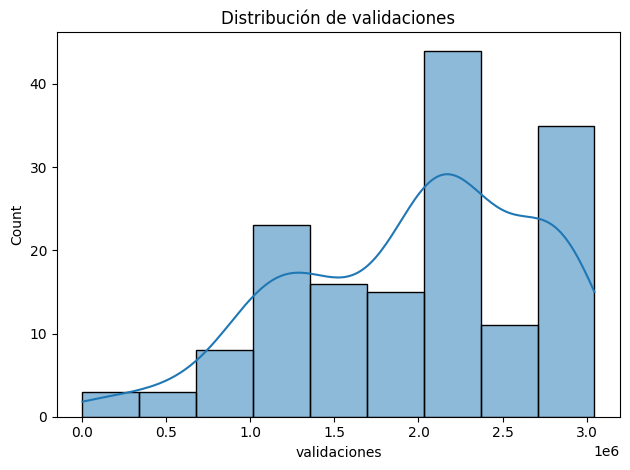

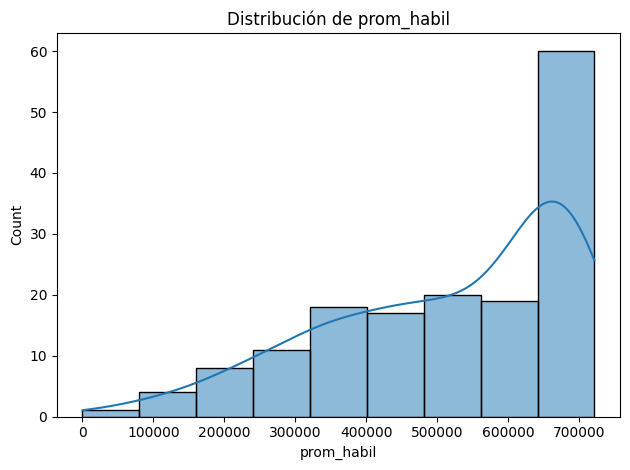

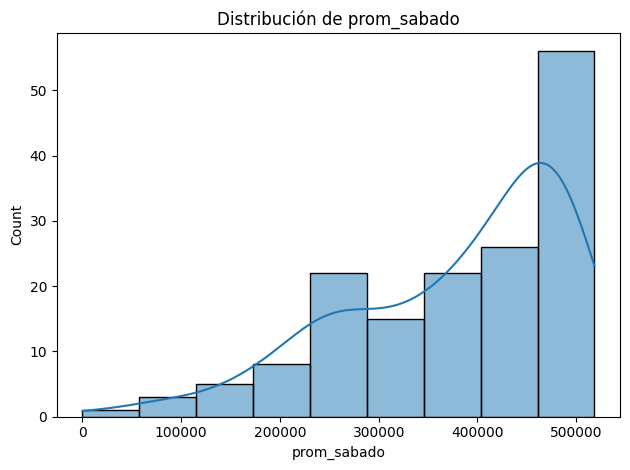

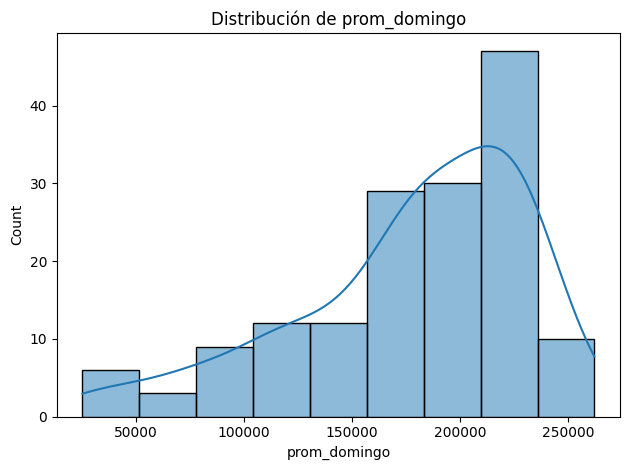

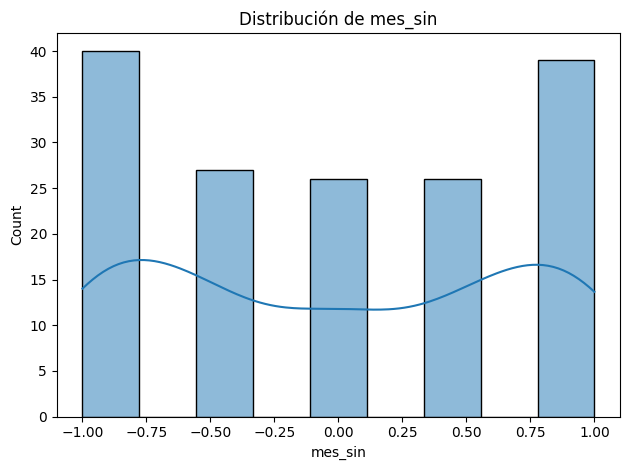

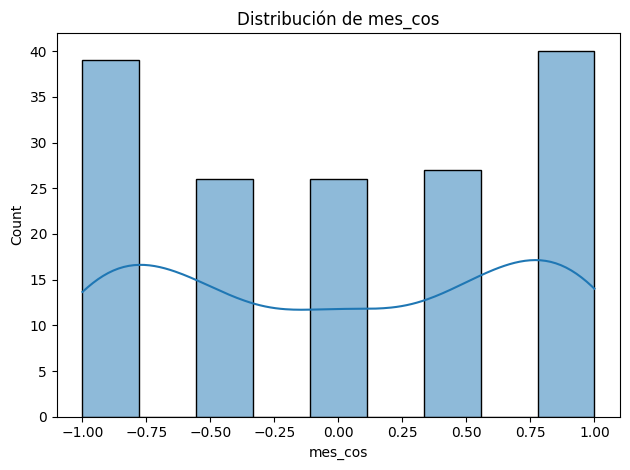

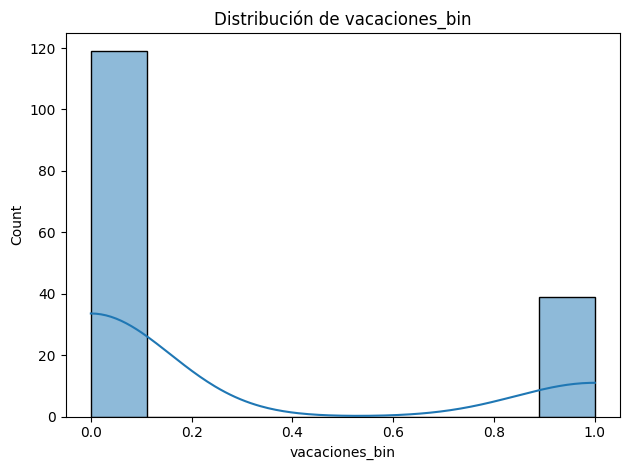

In [ ]:
# 9. Análisis univariante
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribución de {col}")
    plt.tight_layout()
    plt.show()

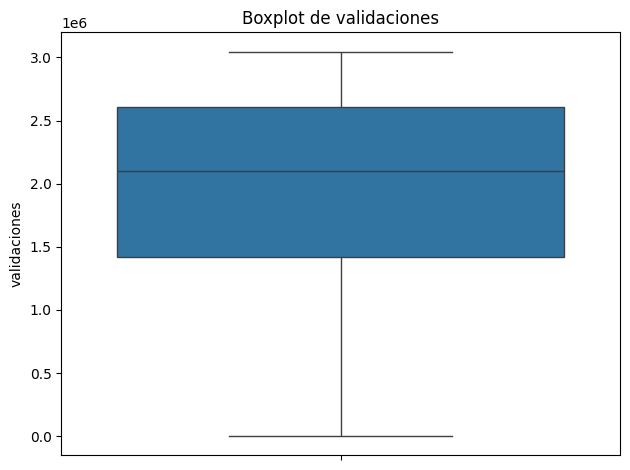

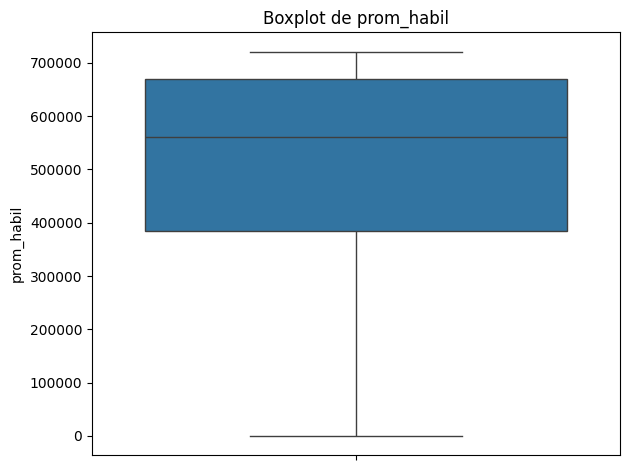

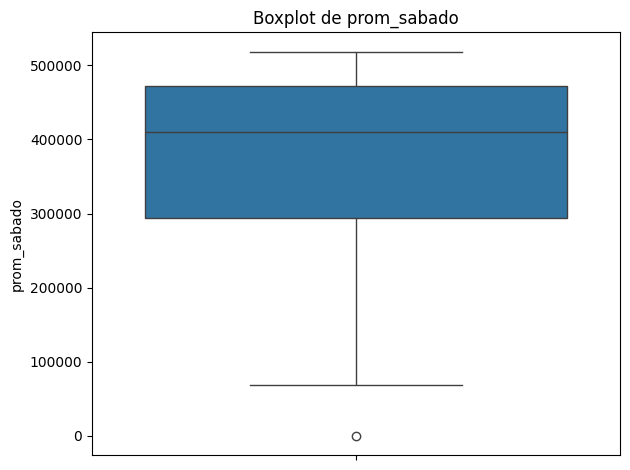

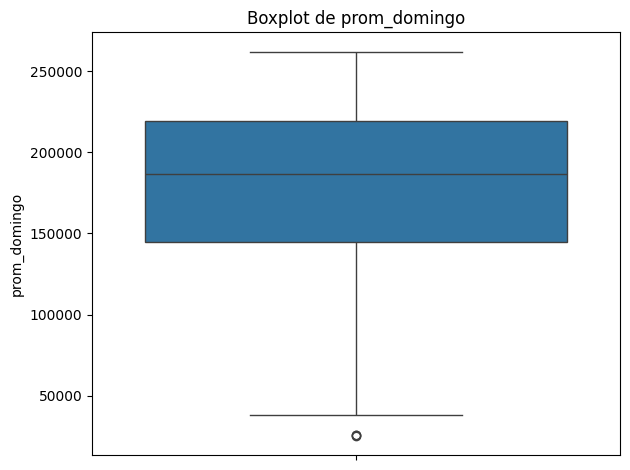

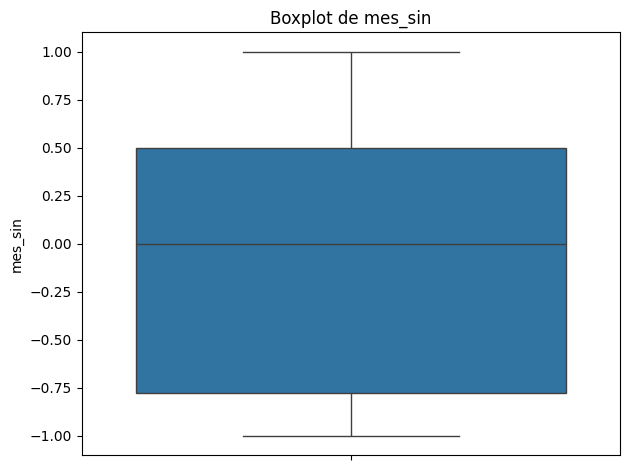

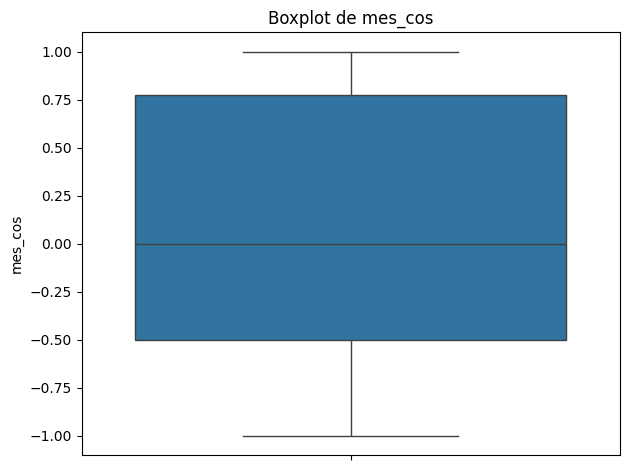

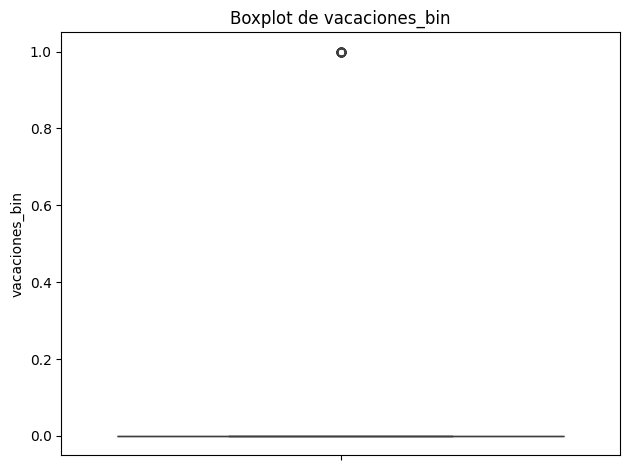

In [ ]:
# 9. Detección de outliers con boxplots
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(data=df[col])
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()


▶ Matriz de correlación:
                 validaciones  prom_habil  prom_sabado  prom_domingo   mes_sin  \
validaciones        1.000000    0.947961     0.957565      0.917491 -0.035869   
prom_habil          0.947961    1.000000     0.981011      0.929934 -0.024538   
prom_sabado         0.957565    0.981011     1.000000      0.935094 -0.046990   
prom_domingo        0.917491    0.929934     0.935094      1.000000 -0.025889   
mes_sin            -0.035869   -0.024538    -0.046990     -0.025889  1.000000   
mes_cos             0.017682   -0.015333     0.001299      0.133300 -0.010814   
vacaciones_bin     -0.003410   -0.021013    -0.032506      0.040324  0.645564   

                 mes_cos  vacaciones_bin  
validaciones    0.017682       -0.003410  
prom_habil     -0.015333       -0.021013  
prom_sabado     0.001299       -0.032506  
prom_domingo    0.133300        0.040324  
mes_sin        -0.010814        0.645564  
mes_cos         1.000000        0.361675  
vacaciones_bin  0.36167

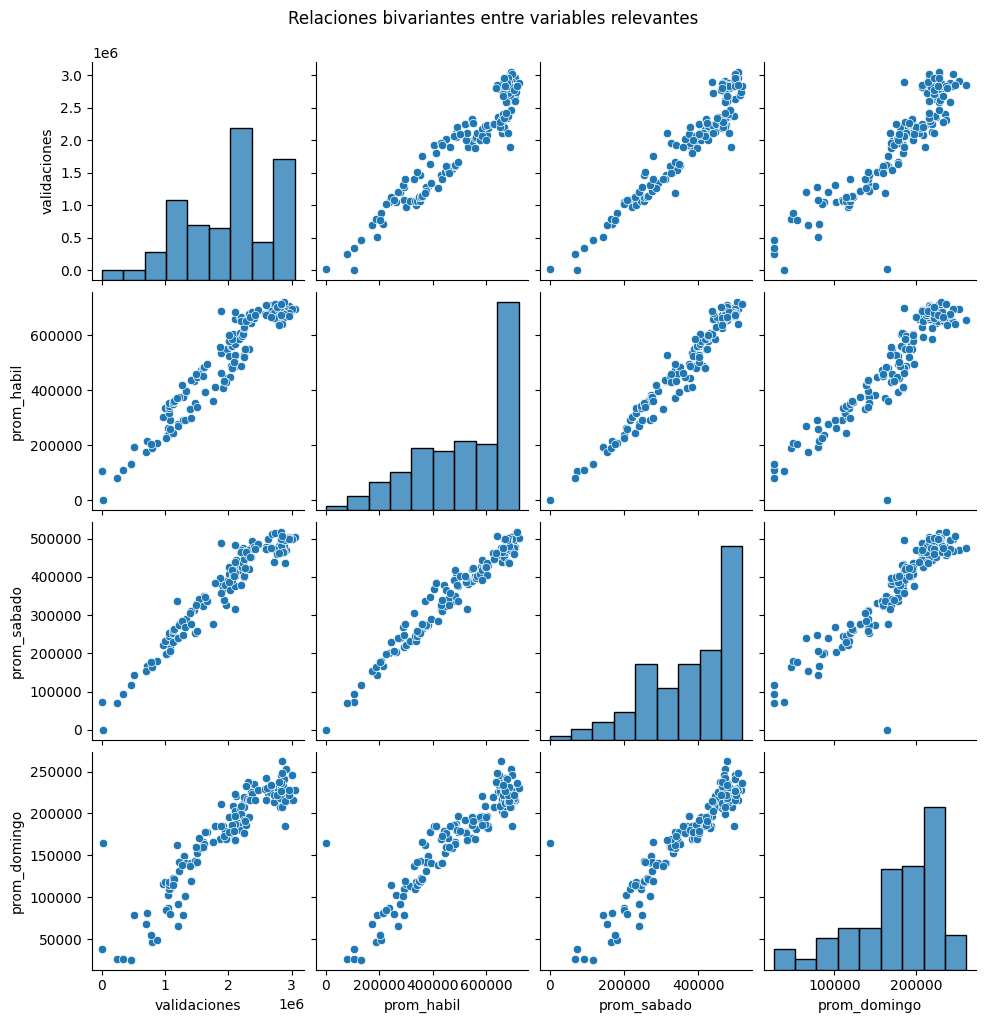

In [ ]:
# 13. Análisis bivariante - correlación y dispersión
print("\n▶ Matriz de correlación:\n", df.corr(numeric_only=True))
sns.pairplot(df[['validaciones', 'prom_habil', 'prom_sabado', 'prom_domingo']])
plt.suptitle("Relaciones bivariantes entre variables relevantes", y=1.02)
plt.show()

### Visualizaciones del Comportamiento de la Demanda

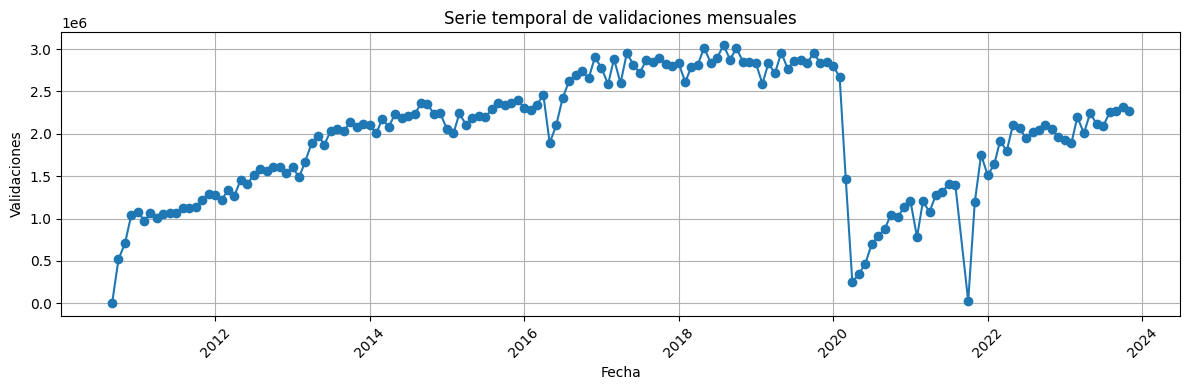

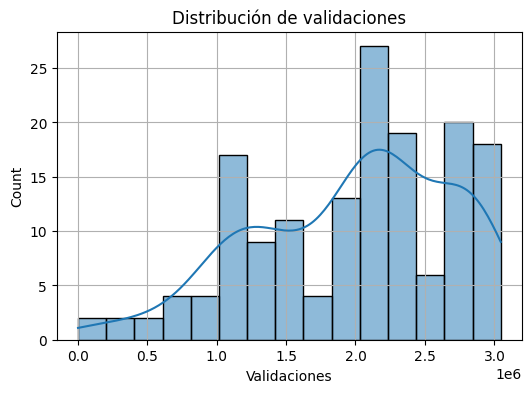

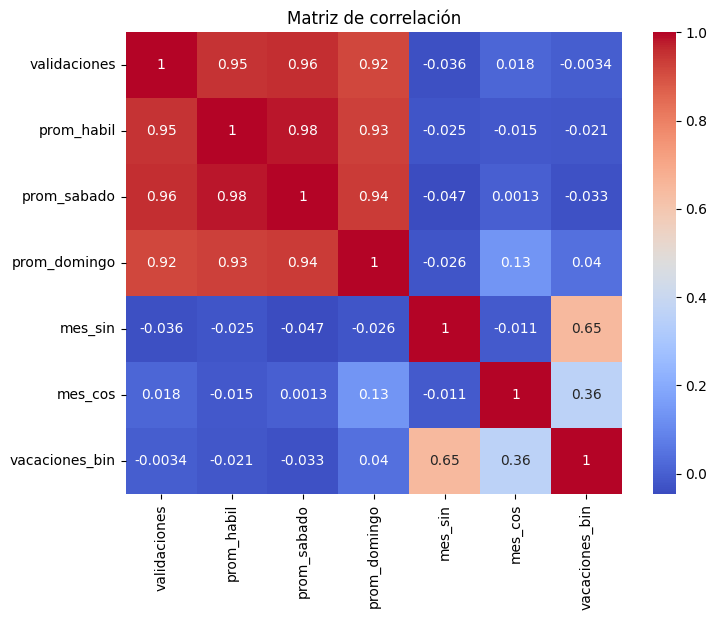

In [ ]:

# Serie temporal de validaciones
plt.figure(figsize=(12, 4))
plt.plot(df['fecha'], df['validaciones'], marker='o')
plt.title("Serie temporal de validaciones mensuales")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograma de validaciones
plt.figure(figsize=(6, 4))
sns.histplot(df['validaciones'], bins=15, kde=True)
plt.title("Distribución de validaciones")
plt.xlabel("Validaciones")
plt.grid(True)
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()


Correlación de las variables con 'validaciones':

validaciones      1.000000
prom_sabado       0.957565
prom_habil        0.947961
prom_domingo      0.917491
mes_cos           0.017682
vacaciones_bin   -0.003410
mes_sin          -0.035869
Name: validaciones, dtype: float64


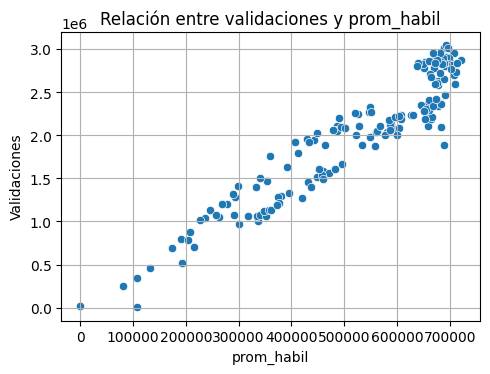

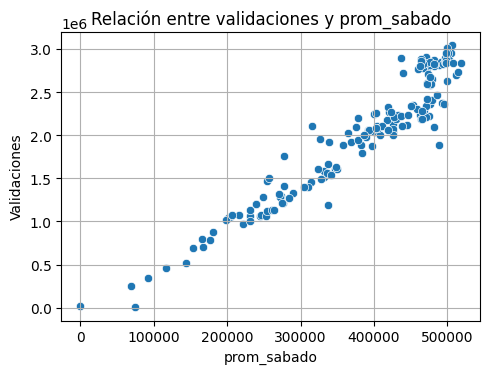

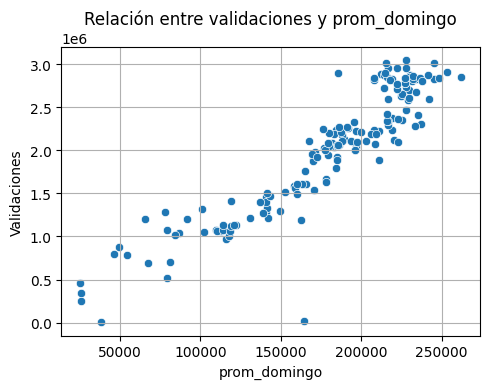

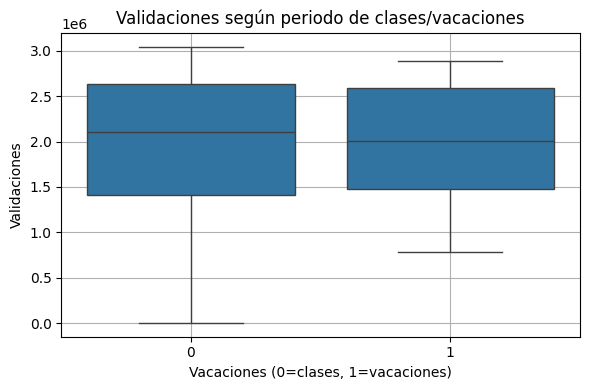

In [ ]:
# Correlación de variables con 'validaciones'
corrs = df.corr(numeric_only=True)['validaciones'].sort_values(ascending=False)
print("Correlación de las variables con 'validaciones':\n")
print(corrs)

# Scatter plots
features_to_plot = ['prom_habil', 'prom_sabado', 'prom_domingo']
for feature in features_to_plot:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=df[feature], y=df['validaciones'])
    plt.title(f'Relación entre validaciones y {feature}')
    plt.xlabel(feature)
    plt.ylabel('Validaciones')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Boxplot para variable categórica 'vacaciones_bin'
plt.figure(figsize=(6, 4))
sns.boxplot(x='vacaciones_bin', y='validaciones', data=df)
plt.title('Validaciones según periodo de clases/vacaciones')
plt.xlabel('Vacaciones (0=clases, 1=vacaciones)')
plt.ylabel('Validaciones')
plt.grid(True)
plt.tight_layout()
plt.show()


### Autocorrelación

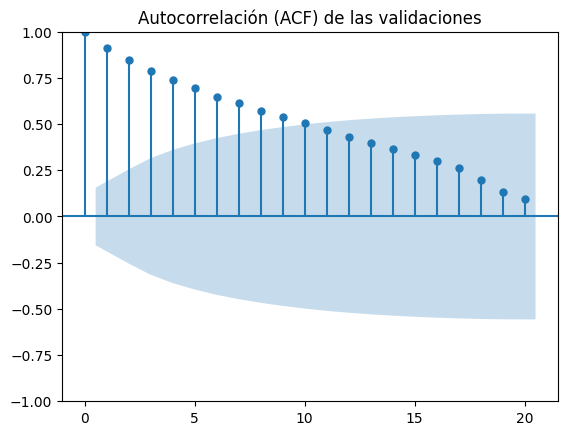

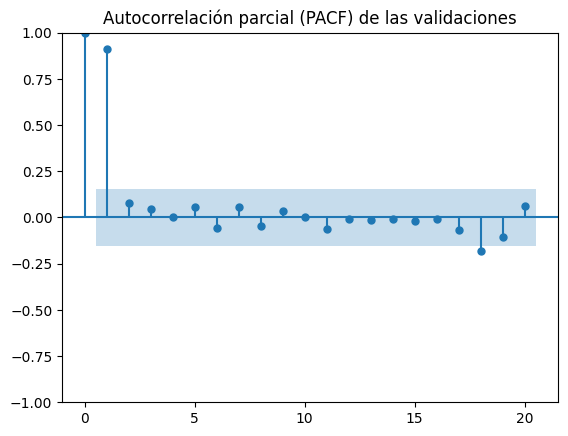

In [ ]:

# ACF y PACF
plot_acf(df['validaciones'], lags=20)
plt.title("Autocorrelación (ACF) de las validaciones")
plt.show()

plot_pacf(df['validaciones'], lags=20)
plt.title("Autocorrelación parcial (PACF) de las validaciones")
plt.show()


## 2. Predicción con RNN, LSTM y GRU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Comparativa de modelos:
  Modelo        R2       MAE       MSE
0    RNN  0.176662  0.070251  0.020059
1   LSTM  0.477386  0.072952  0.012732
2    GRU  0.438936  0.059312  0.013669


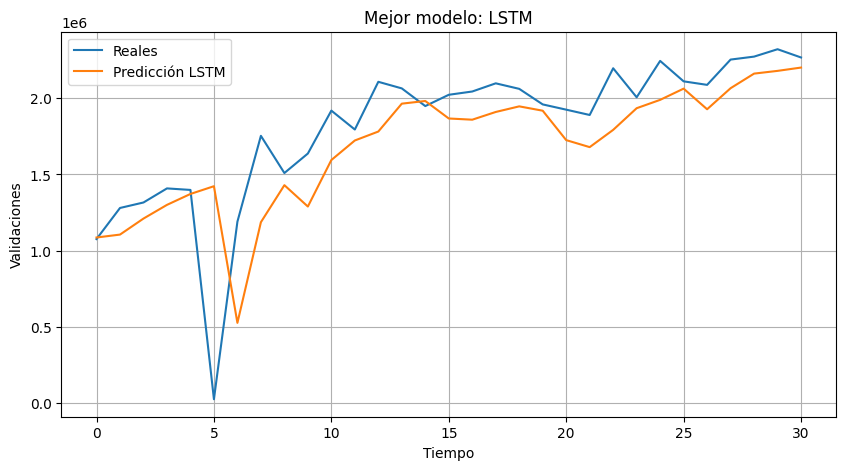


Predicciones futuras (6 meses):
       fecha  prediccion_validaciones
0 2023-12-01             2.166838e+06
1 2024-01-01             2.149809e+06
2 2024-02-01             2.189903e+06
3 2024-03-01             2.209664e+06
4 2024-04-01             2.210855e+06
5 2024-05-01             2.195870e+06


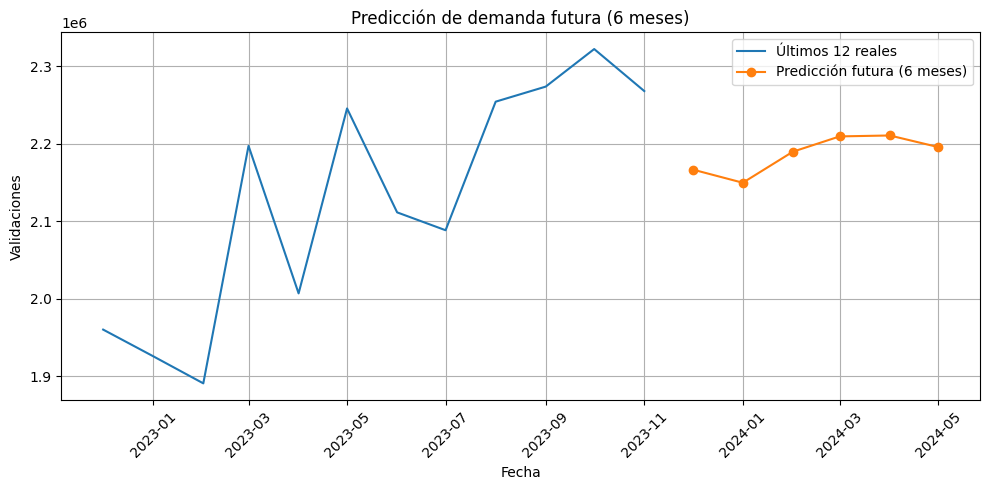

In [29]:
# Predicción de demanda con RNN, LSTM y GRU - Mejor modelo y resultados desnormalizados + Forecast 6 meses futuros

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt


# Normalizar
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=features)

# Crear secuencias
sequence_length = 6
X, y = [], []
for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i]['validaciones'])

X, y = np.array(X), np.array(y)

# Split en train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_dates = df['fecha'][sequence_length + split:].reset_index(drop=True)

# Entrenar y evaluar modelos
results = []
model_predictions = {}

def build_and_evaluate(model_type):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results.append({'Modelo': model_type, 'R2': r2, 'MAE': mae, 'MSE': mse})
    model_predictions[model_type] = y_pred
    return model

# Ejecutar modelos y guardar el mejor
mejor_modelo = None
for model_type in ['RNN', 'LSTM', 'GRU']:
    modelo_actual = build_and_evaluate(model_type)
    if model_type == 'LSTM':
        mejor_modelo = modelo_actual

# Elegir mejor modelo
results_df = pd.DataFrame(results)
best_model_name = results_df.sort_values(by='R2', ascending=False).iloc[0]['Modelo']
best_pred = model_predictions[best_model_name]

# Desnormalizar test y predicciones
validaciones_index = features.index('validaciones')
y_test_real = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features) - 1))])
)[:, 0]
y_pred_real = scaler.inverse_transform(
    np.hstack([best_pred, np.zeros((len(best_pred), len(features) - 1))])
)[:, 0]

# Guardar resultados test
df_resultados = pd.DataFrame({
    'fecha': test_dates,
    'validaciones_reales': y_test_real,
    f'prediccion_{best_model_name}': y_pred_real,
    'error_absoluto': np.abs(y_test_real - y_pred_real)
})
df_resultados.to_excel("predicciones_modelo_ganador.xlsx", index=False)

# Mostrar métricas
print("Comparativa de modelos:")
print(results_df)

# Gráfico del mejor modelo
plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label='Reales')
plt.plot(y_pred_real, label=f'Predicción {best_model_name}')
plt.title(f'Mejor modelo: {best_model_name}')
plt.xlabel('Tiempo')
plt.ylabel('Validaciones')
plt.legend()
plt.grid(True)
plt.show()

# --- Forecast: predicción de 6 meses futuros ---
n_future = 6
last_sequence = scaled_df.iloc[-sequence_length:].values
future_predictions = []

for i in range(n_future):
    input_seq = last_sequence.reshape((1, sequence_length, len(features)))
    pred = mejor_modelo.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(pred)

    # Generar nueva entrada
    new_entry = last_sequence[-1].copy()
    new_entry[0] = pred
    next_month_index = (df['fecha'].dt.month.iloc[-1] + i + 1) % 12
    next_month_index = 12 if next_month_index == 0 else next_month_index
    new_entry[-2] = np.sin(2 * np.pi * next_month_index / 12)
    new_entry[-1] = np.cos(2 * np.pi * next_month_index / 12)
    last_sequence = np.vstack([last_sequence[1:], new_entry])

# Desnormalizar predicciones futuras
future_pred_descaled = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((n_future, len(features)-1))])
)[:, 0]

# Fechas futuras
last_date = df['fecha'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='MS')

# Guardar predicción futura
df_forecast = pd.DataFrame({
    'fecha': future_dates,
    'prediccion_validaciones': future_pred_descaled
})
df_forecast.to_excel("predicciones_futuras_6_meses.xlsx", index=False)
print("\nPredicciones futuras (6 meses):")
print(df_forecast)

# Gráfico de predicciones futuras
plt.figure(figsize=(10, 5))
plt.plot(df['fecha'][-12:], df['validaciones'][-12:], label='Últimos 12 reales')
plt.plot(df_forecast['fecha'], df_forecast['prediccion_validaciones'], label='Predicción futura (6 meses)', marker='o')
plt.title("Predicción de demanda futura (6 meses)")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
